In [1]:
DATA_DIR = '../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab
# PCA_FOLDS_DIR = DATA_DIR + 'pca_folds_2/'

In [2]:
from nilearn import plotting
from nilearn.input_data import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
#from nilearn.image import load_img
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_decomposition import PLSRegression, CCA
import regression_common
import joblib
import matplotlib.pyplot as plt

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

In [3]:
# Create/store/load binary image data
if not os.path.isfile(DATA_DIR + 'binary_imgs.npy'):

    dataset_path = "../sample-dataset/HallymBundang_lesionmaps_Bzdok_n1401/"
    img_filenames = glob.glob(os.path.join(dataset_path, '*.nii.gz'))
    img_filenames.sort()
    print('Number of subjects: %d' % len(img_filenames))

    img_shape = load_img(img_filenames[0]).shape

    mask_img = load_mni152_brain_mask()
    masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache', verbose=5)
    masker = masker.fit()

    imgs = masker.transform(img_filenames) # break down into slices if necessary
    imgs = imgs.astype(bool)
    np.save(DATA_DIR + 'binary_imgs', imgs)

else:
    imgs = np.load(DATA_DIR + 'binary_imgs.npy')

print(imgs.shape)

(1401, 228453)


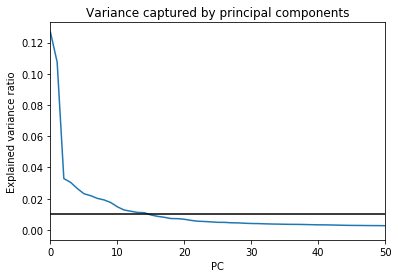

In [110]:
# plot variance explained by components
if not os.path.isfile('../data/pca_all.joblib'): 
    pca_all = PCA(copy=False)
    X_pc_all = pca_all.fit_transform(imgs)
    #np.save('../data/binary_imgs_pc_all.npy', X_pc_all)
    joblib.dump(pca_all, '../data/pca_all.joblib') 

else:
    pca_all = joblib.load('../data/pca_all.joblib') 
    
plt.plot(pca_all.explained_variance_ratio_)
plt.title("Variance captured by principal components")
plt.xlabel("PC")
plt.xlim(0, 50)
plt.axhline(0.01, color="black")
plt.ylabel("Explained variance ratio")
plt.show()

## Multitask analysis with 100 PC components, repeat on every fold

In [4]:
X = imgs
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [6]:
# function to repeat PCA in each fold.

from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def perform_regression_pca_repeat(X, y, estimator, my_grid, random_search_cv=False, n_jobs=-1, random_iter=20,
                       nn=False, callbacks=None, print_r2=False):

    kfold_outer = KFold(n_splits=5)

    scores_df = pd.DataFrame()

    i = 1

    for train, test in kfold_outer.split(X):

        kfold_inner = KFold(n_splits=5)
        
        pca = PCA(n_components=100)
        
        X_train = pca.fit_transform(X[train])
        X_test = pca.transform(X[test])

        y_train = y[train]
        y_test = y[test]

        if random_search_cv:
            gs_est = RandomizedSearchCV(estimator=estimator, param_distributions=my_grid, n_jobs=n_jobs,
                                        cv=kfold_inner, random_state=39, n_iter=random_iter)
        else:
            gs_est = GridSearchCV(estimator=estimator, param_grid=my_grid, n_jobs=n_jobs, \
                                  cv=kfold_inner)

        if nn:
            gs_est.fit(X_train, y_train, nn=True, callbacks=callbacks)

        else:
            gs_est.fit(X_train, y_train)

        y_predicted_train = gs_est.predict(X_train)
        y_predicted_test = gs_est.predict(X_test)

        train_rsq_k = r2_score(y_train, y_predicted_train, multioutput='raw_values')
        test_rsq_k = r2_score(y_test, y_predicted_test, multioutput='raw_values')

        train_mae_k = mean_absolute_error(y_train, y_predicted_train, multioutput='raw_values')
        test_mae_k = mean_absolute_error(y_test, y_predicted_test, multioutput='raw_values')

        train_mse_k = mean_squared_error(y_train, y_predicted_train, multioutput='raw_values')
        test_mse_k = mean_squared_error(y_test, y_predicted_test, multioutput='raw_values')

        scores_df = pd.concat([scores_df, regression_common.create_score_df("R2", "In-sample", i, train_rsq_k)], ignore_index=True)
        scores_df = pd.concat([scores_df, regression_common.create_score_df("R2", "Out-of-sample", i, test_rsq_k)], ignore_index=True)

        scores_df = pd.concat([scores_df, regression_common.create_score_df("MAE", "In-sample", i, train_mae_k)], ignore_index=True)
        scores_df = pd.concat([scores_df, regression_common.create_score_df("MAE", "Out-of-sample", i, test_mae_k)], ignore_index=True)

        scores_df = pd.concat([scores_df, regression_common.create_score_df("MSE", "In-sample", i, train_mse_k)], ignore_index=True)
        scores_df = pd.concat([scores_df, regression_common.create_score_df("MSE", "Out-of-sample", i, test_mse_k)], ignore_index=True)

        print('Fold-'+str(i) + ': Best params:', gs_est.best_params_)
        if print_r2:
            print(train_rsq_k)
            print(test_rsq_k)

        i += 1

    return scores_df

### Multitask Ridge

In [15]:
def perform_multitask_ridge(X, Y):
    print('Performing Multitask Ridge regression (5-fold nested CV)')
    estimator = MultiTaskElasticNet(l1_ratio=0.0001)
    alpha = np.linspace(0, 100, 51)
    my_grid={"alpha": alpha}
    return perform_regression_pca_repeat(X, Y, estimator, my_grid)

In [16]:
scores_mr = perform_multitask_ridge(X, Y)

Performing Multitask Ridge regression (5-fold nested CV)
Fold-1: Best params: {'alpha': 62.0}
Fold-2: Best params: {'alpha': 40.0}
Fold-3: Best params: {'alpha': 32.0}
Fold-4: Best params: {'alpha': 26.0}
Fold-5: Best params: {'alpha': 48.0}


### PLS

In [17]:
def perform_pls_regression(X, Y):
    print('Performing PLS regression (5-fold nested CV)')
    estimator = PLSRegression()
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return perform_regression_pca_repeat(X, Y, estimator, my_grid)

In [18]:
scores_pls = perform_pls_regression(X, Y)

Performing PLS regression (5-fold nested CV)
Fold-1: Best params: {'n_components': 1}
Fold-2: Best params: {'n_components': 1}
Fold-3: Best params: {'n_components': 1}
Fold-4: Best params: {'n_components': 1}
Fold-5: Best params: {'n_components': 1}


### CCA

In [19]:
def perform_cca(X, Y):
    print('Performing CCA (5-fold nested CV)')
    estimator = CCA(n_components=6)
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return perform_regression_pca_repeat(X, Y, estimator, my_grid)

In [20]:
scores_cca = perform_cca(X, Y)

Performing CCA (5-fold nested CV)
Fold-1: Best params: {'n_components': 1}
Fold-2: Best params: {'n_components': 1}
Fold-3: Best params: {'n_components': 1}
Fold-4: Best params: {'n_components': 1}
Fold-5: Best params: {'n_components': 1}


### Random Forest Regression

In [21]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [100, 500, 1000, 1500]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2, 5, 10, 50, None]
    min_samples_split = [1, 2, 5, 10, 15]
    min_samples_leaf = [2, 4, 8, 12]
    max_samples = [0.5, 0.7, 0.8, 0.9]
    
    my_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return perform_regression_pca_repeat(X, Y, estimator, my_grid, random_search_cv=True)


In [22]:
scores_rf = perform_random_forest_regr(X, Y)

Performing Random Forest regression (5-fold nested CV)
Fold-1: Best params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'auto', 'max_depth': 5}
Fold-2: Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.5, 'max_features': 'log2', 'max_depth': 50}
Fold-3: Best params: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 50}
Fold-4: Best params: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 50}
Fold-5: Best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 50}


### Neural Net 

In [23]:
def build_model(l1_units, l2_units, l3_units, lr, l2_reg):
    model = Sequential()
    model.add(Dense(l1_units, input_dim=100, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l2_units, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l3_units, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(Y.shape[1], activation=None, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))

    adam = Adam(lr=lr)
    model.compile(loss='mse', metrics=['mae'], optimizer=adam)
    return model

def perform_nn_regression(X, Y):

    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True)
    estimator = KerasRegressor(build_fn=build_model, epochs=100, batch_size=256, verbose=0)
    
    lr = [0.050, 0.025, 0.010, 0.005]
    l1_units = [35]
    l2_units = [25]
    l3_units = [15]
    l2_reg = [0.001, 0.00005, 0.00001, 0.000001, 0.00000]

    my_grid = {'l1_units': l1_units,
               'l2_units': l2_units,
               'l3_units': l3_units,
               'lr': lr,
               'l2_reg': l2_reg}

    return perform_regression_pca_repeat(X, Y, estimator, my_grid, random_search_cv=False, \
                                                nn=True, callbacks=[es], n_jobs=-1)


In [24]:
scores_nn = perform_nn_regression(X, Y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fold-1: Best params: {'l1_units': 35, 'l2_reg': 1e-06, 'l2_units': 25, 'l3_units': 15, 'lr': 0.025, 'epochs': 4}
Fold-2: Best params: {'l1_units': 35, 'l2_reg': 1e-05, 'l2_units': 25, 'l3_units': 15, 'lr': 0.01, 'epochs': 10}
Fold-3: Best params: {'l1_units': 35, 'l2_reg': 1e-05, 'l2_units': 25, 'l3_units': 15, 'lr': 0.025, 'epochs': 6}
Fold-4: Best params: {'l1_units': 35, 'l2_reg': 0.0, 'l2_units': 25, 'l3_units': 15, 'lr': 0.05, 'epochs': 7}
Fold-5: Best params: {'l1_units': 35, 'l2_reg': 1e-05, 'l2_units': 25, 'l3_units': 15, 'lr': 0.01, 'epochs': 9}


In [7]:
def build_model_linear(l1_units, l2_units, l3_units, lr, l2_reg):
    model = Sequential()
    model.add(Dense(l1_units, input_dim=100, activation=None, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l2_units, activation=None, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(l3_units, activation=None, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dense(Y.shape[1], activation=None, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))

    adam = Adam(lr=lr)
    model.compile(loss='mse', metrics=['mae'], optimizer=adam)
    return model

def perform_nn_linear_regression(X, Y):

    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0001, patience=3, restore_best_weights=True)
    estimator = KerasRegressor(build_fn=build_model_linear, epochs=100, batch_size=256, verbose=0)
    
    lr = [0.07, 0.050, 0.025, 0.010, 0.005, 0.001]
    l1_units = [25]
    l2_units = [15]
    l3_units = [10]
    l2_reg = [0.001, 0.00005, 0.00001, 0.000001, 0.00000]

    my_grid = {'l1_units': l1_units,
               'l2_units': l2_units,
               'l3_units': l3_units,
               'lr': lr,
               'l2_reg': l2_reg}

    return perform_regression_pca_repeat(X, Y, estimator, my_grid, random_search_cv=False, \
                                                nn=True, callbacks=[es], n_jobs=-1)


In [8]:
scores_nn_linear = perform_nn_linear_regression(X, Y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fold-1: Best params: {'l1_units': 25, 'l2_reg': 1e-06, 'l2_units': 15, 'l3_units': 10, 'lr': 0.05, 'epochs': 14}
Fold-2: Best params: {'l1_units': 25, 'l2_reg': 0.0, 'l2_units': 15, 'l3_units': 10, 'lr': 0.05, 'epochs': 15}
Fold-3: Best params: {'l1_units': 25, 'l2_reg': 5e-05, 'l2_units': 15, 'l3_units': 10, 'lr': 0.07, 'epochs': 20}
Fold-4: Best params: {'l1_units': 25, 'l2_reg': 5e-05, 'l2_units': 15, 'l3_units': 10, 'lr': 0.05, 'epochs': 14}
Fold-5: Best params: {'l1_units': 25, 'l2_reg': 1e-05, 'l2_units': 15, 'l3_units': 10, 'lr': 0.05, 'epochs': 17}


In [25]:
# organize results and plot
scores_all_models = pd.DataFrame()

scores_mr.insert(0, "Model", "Multitask Ridge")
scores_pls.insert(0, "Model", "PLS")
scores_cca.insert(0, "Model", "CCA")
scores_rf.insert(0, "Model", "Random Forest")
scores_nn.insert(0, "Model", "Neural Network")
scores_nn_linear.insert(0, "Model", "Neural Network (Linear)")

scores_all_models = pd.concat([scores_mr, scores_pls, scores_cca, scores_rf, scores_nn, scores_nn_linear], ignore_index=True)

In [16]:
# persist results
scores_all_models.to_hdf('../data/results_pca_100_repeat_fold_multioutput.h5', key='p', mode='w')
# scores_all_models = pd.read_hdf('../data/results_pca_100_repeat_fold_multioutput.h5', key='p', mode='r')

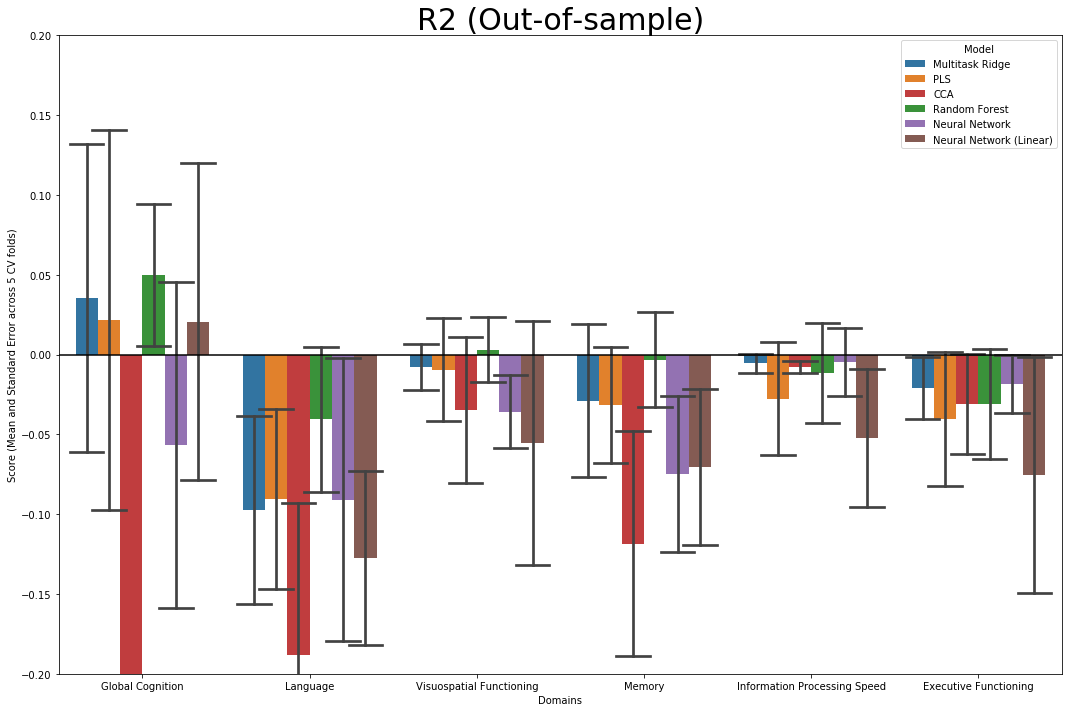

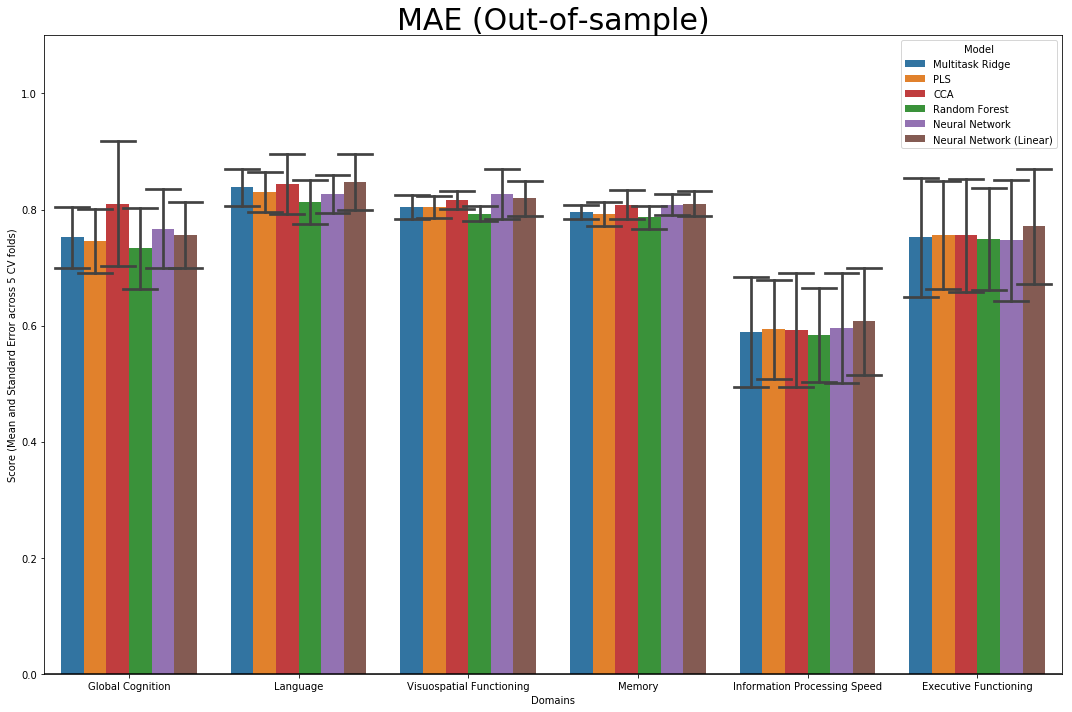

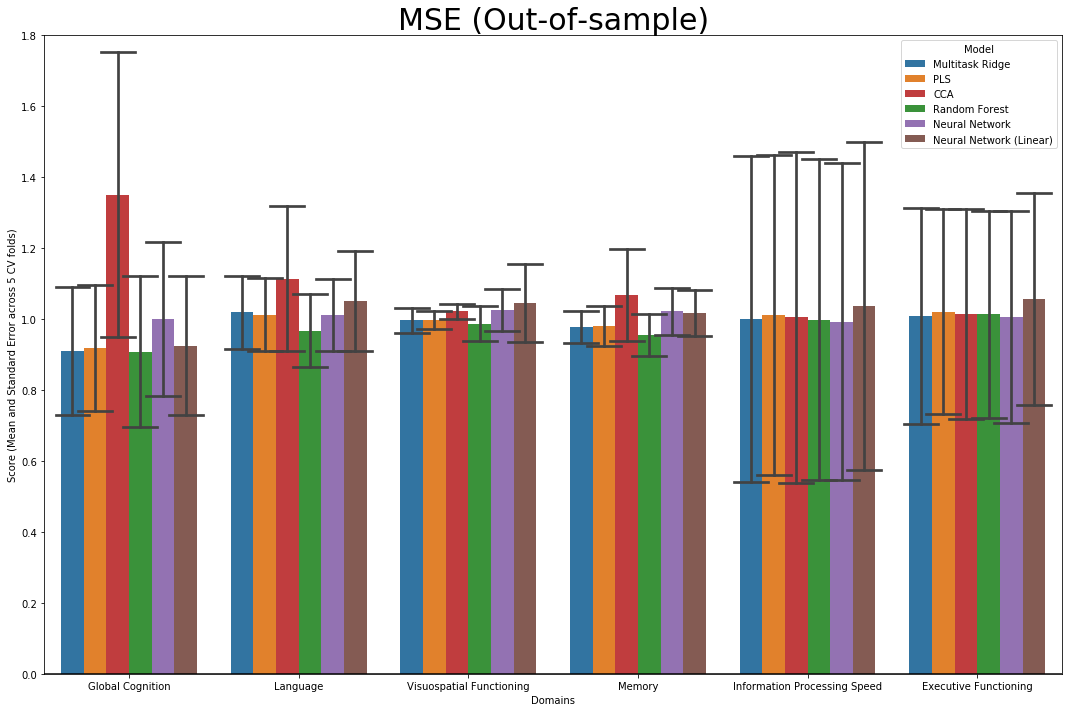

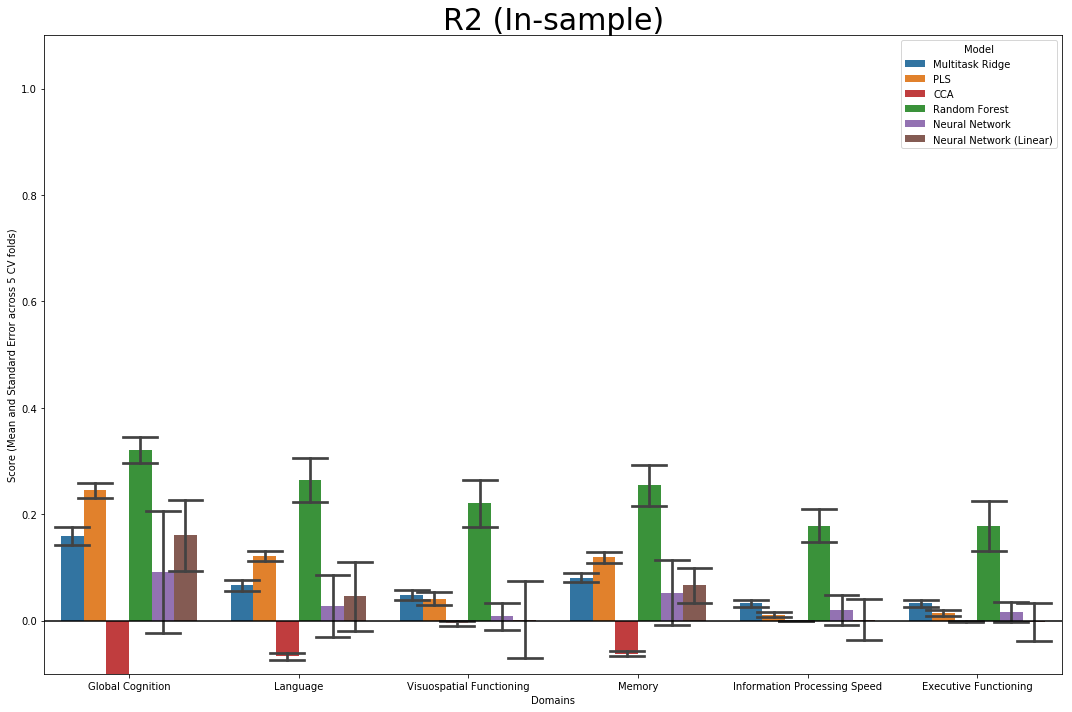

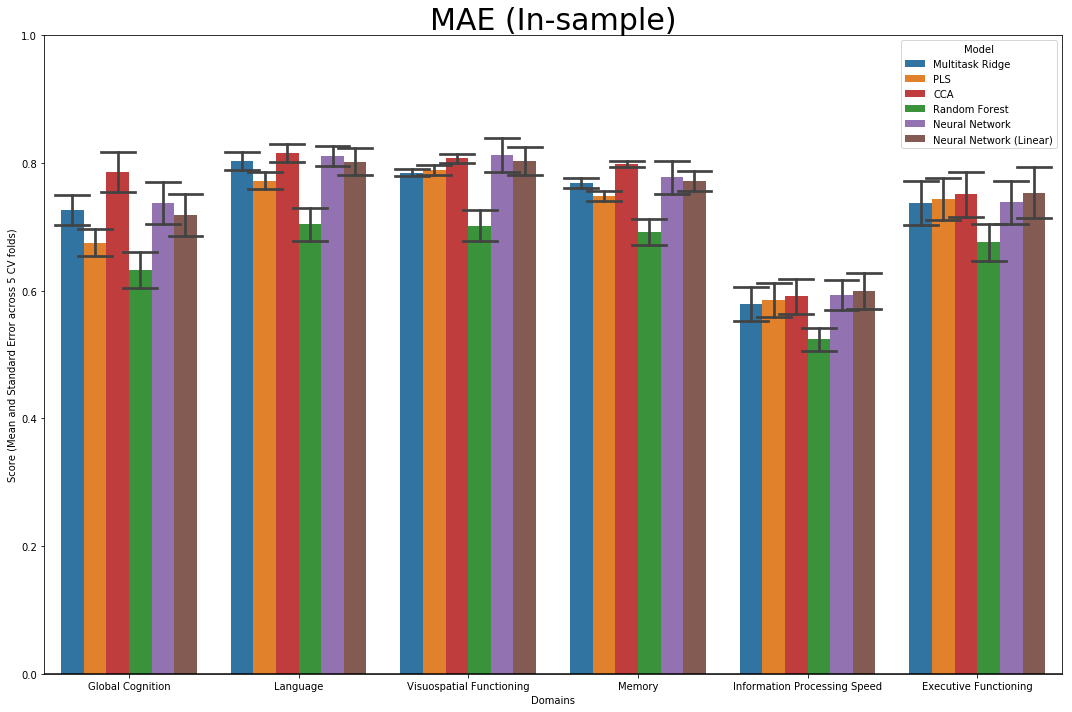

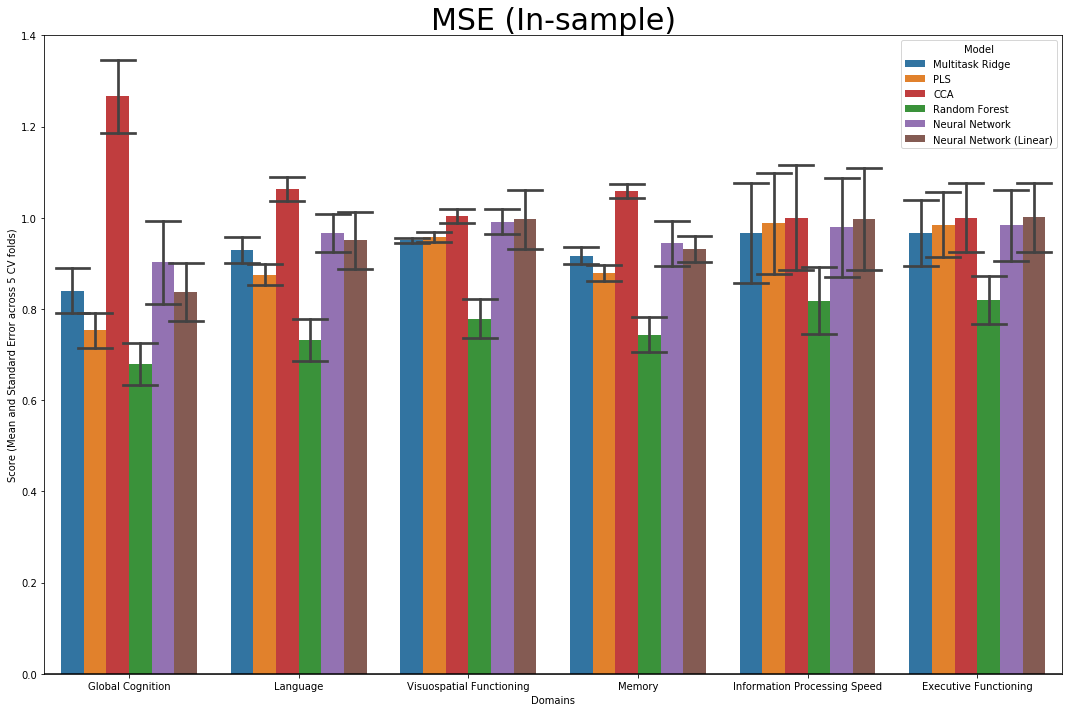

In [18]:
regression_common.plot_all_scores(scores_all_models, hue_order=['Multitask Ridge', 'PLS', 'CCA', 'Random Forest',
                                               'Neural Network', 'Neural Network (Linear)'])